# Logistic Regression with Fast Gradient Descent

### Author: Juan Solorio

-----

# Overview
In this exercise, I will implement a first version of my own own fast gradient algorithm to solve the $l^2_2$-regularized logistic regression problem. I will be building on the stocastic gradient descent algorithm and adding a backtracking function for the gradient descent algorithm.

## Objectives
- Mathematically define _Objective Function_ for Logistic Regression ($F(\beta)$)
    - Compute gradiant $\nabla F$
- Create functions for algorithm:
    - Objective function
    - Gradient function
    - Fast Gradient Descent funtion & gradient descent function and compare
    - Backtracking Line Search function
    - Check misclassification error
    
- Observe (plot) the convergence in terms of the function values and the gradients  
    and tune for the optimal hyperparameters for step-size ($\eta$) and normalization ($\lambda$)
- Compare to _sklearn_


## Environment Setup - *Importing Libraries*

In [1]:
# needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import time

%matplotlib inline
plt.style.use('ggplot')

# Background and Theory

***logistic Regression*** is a type of _Supervised Machine Learning_ algorithm with the purpose to be used in ***binary classification***, as such this algorithm is confine to make predictions between {0,1} or {-1,1}. Given that we are trying to make this binary prediction of our target variable, we are dealing with a model trying to get variables where the probabilities are bounded on both ends (they must be between 0 and 1). 

We start with the traditional definition of the _Linear Regression_ formula:
$$
y = b_0*x + b_1
$$
> y - target value  
$b_0$ - slope  
x - predictor variable  
$b_1$ - intercept

However, given linear regression gives _unbounded_ solutions, we must _restrict_ the function by wrapping it around or passing it through a **link function**. We start by taking our linear function and defining it in terms of the statistical ***Odds*** of the given event occuring:
> $P(Y=1 | X=x)$, read as the probability of $Y=1$ given that $X$ is already value $x$.  
$Odds=\frac{P}{1-P}$, the _Odds_ of something happening is the probability of it _happening_ devided by it _not happening_ .

We then transform our linear model and Odds of occurance into our _logistic regression_ :
$$
Ln(\frac{P}{1-P}) = b_0*x + b_1 \\
\Rightarrow \frac{P}{1-P} = e^{b_0*x + b_1} \\
\Rightarrow P = e^{b_0*x + b_1} * (1-P) \\
\Rightarrow e^{b_0*x + b_1} = P + P*e^{b_0*x + b_1}  \\
\Rightarrow P = \frac{e^{b_0*x + b_1}}{1+e^{b_0*x + b_1}} \\
$$

As we can observe this final result is what is known as passing our linear regression through the ***Sigmoid function***:
>a mathematical function having a characteristic "S"-shaped curve or **sigmoid curve**
$$
S(x) = \frac{1}{1+e^{-x}}
$$


## Logistic Regression
We can generalize the *Logistic Regression* ***objective function*** as:
$$
F(\beta) = \min_{\beta}F(\beta) = \frac{1}{n}\sum_{i=1}^n log(1 + exp^{-y_ix^T_i\beta}) + \lambda\|\beta\|^2_2
$$

or equivalently

\begin{equation}
\min_{\beta}F(\beta) = \frac{1}{n}\sum_{i=1}^n log(1 + exp^{-y_i\sum^d_{j=1}x^T_{i,j}\beta_j}) + \lambda\sum_{j=1}^d\beta_j^2
\end{equation}

Using the machine learning convention for the labels that is $y_i\ \in$ {−1, +1}

Assuming $d=1$ and $n=1$, we can compute the $\nabla F$ as follows:

\begin{equation}
F(\beta) = log(1 + exp^{-yx\beta}) + \lambda\beta^2
\end{equation}
\begin{equation}
\Rightarrow \frac{\partial F}{\partial \beta} = \frac{(-yx)exp^{-yxb}}{(1 + exp^{-yx\beta})} + 2\lambda\beta
\end{equation}
\begin{equation}
\Rightarrow \nabla F(\beta) = 2\lambda \beta - \frac{yx}{(1 + exp^{-yx\beta})* exp^{yx\beta}}
\end{equation}
\begin{equation}
\Rightarrow \nabla F(\beta) = 2\lambda \beta - \frac{yx}{exp^{yx\beta} + 1}
\end{equation}

We then generalize for $d>1$ and $n>1$ as:
$$
\nabla F(\beta) = -\frac{1}{n}\sum_{i=1}^n \frac{yx}{exp^{yx\beta} + 1} + 2\lambda \beta
$$


# Algorithm Function Definition

* Objective function for _Logistic Regression_ $F(\beta)$:
>$$
F(\beta) = \min_{\beta}F(\beta) = \frac{1}{n}\sum_{i=1}^n log(1 + exp^{-y_ix^T_i\beta}) + \lambda\|\beta\|^2_2
$$

In [23]:
def obj_fx(beta,lamda,X,y):
    """
    Linear regression with Ridge penalty L1:
    F(b) = 1/n sum(log(1 + exp(-y*x dotproduct b))) + lamda*norm(b)^2
    
    Parameters
    ----------
    beta : arr
        array of values for weights
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data

    Returns
    -------
    int
        computation of the logistic regression objective function

    """
    
    # dot product can be accomplish by 'numpy_arrayA @ numpy_arrayB' or 'numpy_arrayA.dot(numpy_arrayB)'
    return 1/len(y) * np.sum(np.log(1 + np.exp(-y*X.dot(beta)))) + lamda * np.linalg.norm(beta)**2

def obj_fx_alt(b, lamda,X,y):
    h = X @ b * y
    return (1/len(y)) * sum(np.log(1 + np.exp(-h))) + (lamda * np.linalg.norm(b)**2)

* Gradient of the logistic regression objective function - $\nabla F$
> $$\nabla F(\beta) = -\frac{1}{n}\sum_{i=1}^n \frac{yx}{exp^{yx\beta} + 1} + 2\lambda \beta$$

In [15]:
def gradient_fx(beta,lamda,X,y):
    """
    Computes gradient of the Linear regression with Ridge penalty L1 function:
    grad F(b) = -1/n sum(yx / (exp(y*x dotproduct b)+1)) + 2*lamda*b
    
    Parameters
    ----------
    beta : arr
        array of values for weights
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data

    Returns
    -------
    int
        computation of the gradient of Logistic regression objective function

    """
    yx = y[:, np.newaxis]*X
    denom = 1+np.exp(-yx.dot(beta))
    grad = 1/len(y)*np.sum(-yx*np.exp(-yx.dot(beta[:, np.newaxis]))/denom[:, np.newaxis], axis=0) + 2*lamda*beta
    return grad

def gradient_fx_alt(b, lamda,X,y):
    h = X @ b * y 
    return 2*lamda*b - (1/len(y) * (X.T @ (y / (np.exp(h) + 1)))) 

* Backtracking algorithm
> **initialize** $\eta_t = \eta_{t-1}$ if $t \geq 1$  
$\eta_0 = \frac{1}{L_{est}}$  
**Iterate** $\eta_t = \gamma \eta_t$  
_Until condition met_

In [61]:
def backtracking(beta, lamda, X, y, eta=1, alpha=0.5, gamma=0.8, maxiter=100):
    """
    Computes backtracking linear search algorithm:
    F(B_t − η∇F(B_t)) ≤ F(B_t) + αη||∇F(B_t)||^2
    
    Parameters
    ----------
    beta : arr
        array of values for weights
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data
    eta: int
        integer value for step size parameter
    alpha: int
        integer value for stepsize change
    gamma: int
        integer value 

    Returns
    -------
    int
        computation of the change in eta

    """

    grad_beta = gradient_fx(beta, lamda, X, y)
    norm_grad_beta = np.linalg.norm(grad_beta)
    found_eta = 0
    num_iters = 0
    while found_eta == 0 and num_iters < maxiter:
        if obj_fx(beta - eta * grad_beta, lamda, X,y) < obj_fx(beta, lamda, X, y) - alpha * eta * norm_grad_beta ** 2:
            found_eta = 1
        elif num_iters == maxiter:
            raise ('Max number of iterations of backtracking line search reached')
        else:
            eta *= betaparam
            num_iters += 1
    return eta


* Gradient Descent Algorith:
>`Gradient Descent algorithm with fixed constant step-size  
__input__  step-size $\eta$  
__initialization__ $\beta_0 = 0$  
__repeat for__ t = 0, 1, 2, . . .  
    $\beta_{t+1} = \beta_t − \eta \nabla F(\beta_t)$  
__until__ the stopping criterion $\|\nabla F\| \leq \epsilon$ is satisfied.


In [69]:
def gradient_descent(beta_init, eta_init ,lamda,X,y,epsilon=0.005):
    """
    Computes gradient descent with a fixed step size eta and stopping condition norm gradient F < epislon
    
    Parameters
    ----------
    beta_init : arr
        array of values for weights as starting point
    eta_init : int
        interger value for step size parameter
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data
    epsilon : int
        interger value for stopping parameter condition, defaul = 0.005

    Returns
    -------
     beta_vals: Matrix 
         Estimated betas at each iteration, with the most recent values in the last row
    """
    # setting initial value of betas
    beta = beta_init
    eta = eta_init
    # gradient calculation for starting values
    gradient = gradient_fx(beta,lamda,X,y)
    # list to save beta values 
    beta_vals = [beta_init]
    # loop for stopping criterion epsilon
    while np.linalg.norm(gradient) > epsilon:
        # updating values for eta, beta and gradient
        eta = backtracking_1(beta, lamda, eta=eta, X=X, y=y)
        beta = beta - eta*gradient
        gradient = gradient_fx(beta,lamda,X,y)
        
        # appending values
        beta_vals.append(beta)
    return np.array(beta_vals)


* Fast Gradient Descent Algorithm:
> **input** step-size $\eta_0$, target accuracy $\epsilon$  
**initialization** $\beta_0 = 0$, $\theta_0 = 0$  
**repeat** for $t = 0, 1, 2, . . .$  
**Find** $\eta_t$ with backtracking rule  
    $\beta_{t+1} = \theta_t - \eta_t \nabla F(\eta_t)$  
    $\theta_{t+1} = \beta_{t+1} + \frac{t}{t+3}(\beta_{t+1} - \beta_t)$  
**until** the stopping criterion $||\nabla F|| \leq \epsilon$.  

In [91]:
def fast_gradient_algo(beta_init, theta_init, eta_init,lamda, X,y,epsilon=0.005):
    """
    Computes Fast gradient descent with a initial conditions beta_init, theta_init, fixed step size eta
    and stopping condition norm gradient F < epislon
    
    Parameters
    ----------
    beta_init : arr
        array of values for weights as starting point
    eta_init : int
        interger value for step size parameter
    theta_init : int
        interger value for updating beta parameter
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data
    epsilon : int
        interger value for stopping parameter condition, defaul = 0.005

    Returns
    -------
     beta_vals: Matrix 
         Estimated betas at each iteration, with the most recent values in the last row
    """
    # setting initial value of betas
    beta = beta_init
    eta = eta_init
    theta = theta_init
    # gradient calculation for starting values
    grad = gradient_fx(theta,lamda,X,y)
    # list to save beta values 
    beta_vals = [beta_init]
    num_iters = 0
    # loop for stopping criterion epsilon
    while np.linalg.norm(grad) > epsilon:
        # updating values for eta, beta and gradient
        eta = backtracking_1(beta, lamda, eta=eta, X=X, y=y)
        beta_new = theta - eta*grad
        theta = beta_new + num_iters/(num_iters+3)*(beta_new-beta)
        
        # appending values
        beta = beta_new
        beta_vals.append(beta)
        
        grad = gradient_fx(theta,lamda,X,y)
       
        num_iters += 1
        
    return np.array(beta_vals)


# Implementation

For testing our _logistic Regression_ algorithm, we'll be using the ___Spam___ dataset from `'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data'` for out features and `'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.traintest'` for our target variable, and we'll drop the samples with `NA` values.

In [7]:
# Load the data
spam = pd.read_table("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data",sep=" ", header=None)
spam['indicator'] = pd.read_table("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.traintest",header=None) 
spam = spam.dropna()

spam.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,indicator
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1,0
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1,0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1,0


In [62]:
# Create our X matrix with the predictors and y vector with the response
X = spam.drop("indicator", axis=1)
y = spam.indicator
y.replace(0,-1,inplace=True)
# Divide the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1, 1))
# Keep track of the number of samples and dimension of each sample
n_train = len(y_train)
n_test = len(y_test)


In [63]:
# Variable to load into functions
lamda = 0.5
L = (np.max(np.linalg.eig(1/len(y_train)*X_train.T@X_train)[0])) + lamda
eta_init = 1/L
d = X_train.shape[1]
beta_init = np.zeros(d)
theta_init = np.zeros(d)
maxiter = 1000


In [64]:
# store starting time 
begin = time.time()
print(gradient_fx(beta=beta_init,lamda=lamda,X=X_train,y=y_train))
time.sleep(1) 
# store end time 
end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}") 

# store starting time 
begin = time.time()
print(computegrad(b=beta_init, lamda=lamda,X=X_train,y=y_train))
time.sleep(1) 
# store end time 
end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}") 


[ 0.02032379  0.0027978  -0.00584371  0.00202893 -0.00126049  0.00671368
 -0.00065947  0.00121773 -0.01000378  0.00207672 -0.00820628 -0.00858195
 -0.00094936 -0.01933799  0.0020736  -0.01503039 -0.00170232  0.00161148
  0.00071245 -0.01061828  0.00350524  0.00459303  0.00163439 -0.00363655
 -0.00080175 -0.00234983  0.00323827 -0.00892796  0.01102586 -0.00145684
 -0.00163501  0.00535138 -0.00677281  0.005918   -0.00181521  0.00446524
  0.00861823  0.00627413  0.00205909  0.00170645  0.00752408  0.00109195
  0.00468198 -0.00098964  0.00613565 -0.0003137  -0.00225585 -0.00293253
 -0.00110998 -0.00093037  0.01690183  0.00284367  0.00756908  0.01537267
  0.00131323  0.00384906  0.00171852  0.00559917]
Total runtime of the program is 1.0137851238250732
[ 0.02032379  0.0027978  -0.00584371  0.00202893 -0.00126049  0.00671368
 -0.00065947  0.00121773 -0.01000378  0.00207672 -0.00820628 -0.00858195
 -0.00094936 -0.01933799  0.0020736  -0.01503039 -0.00170232  0.00161148
  0.00071245 -0.0106182

In [65]:
# store starting time 
begin = time.time()
print(obj_fx(beta=beta_init,lamda=lamda,X=X_train,y=y_train))
time.sleep(1) 
# store end time 
end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}") 

# store starting time 
begin = time.time()
print(Fx_logisticReg(b=beta_init, lamda=lamda,X=X_train,y=y_train))
time.sleep(1) 
# store end time 
end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}") 


0.6931471805599453
Total runtime of the program is 1.0062980651855469
0.6931471805599352
Total runtime of the program is 1.008281946182251


In [92]:
# Initializing gradient decent and fast algorithm grad descent
begin = time.time()
graddesc = gradient_descent(beta_init, eta_init ,lamda,X=X_train,y=y_train,epsilon=0.005)
time.sleep(1) 
# store end time 
end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}")

# store starting time 
begin = time.time()
fastAlgo = fast_gradient_algo(beta_init, theta_init, eta_init,lamda, X=X_train,y=y_train,epsilon=0.005)
time.sleep(1) 
# store end time 
end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}")


Total runtime of the program is 1.54715895652771
Total runtime of the program is 1.277160406112671


In [88]:
graddesc.shape, fastAlgo.shape

((14, 58), (7, 58))

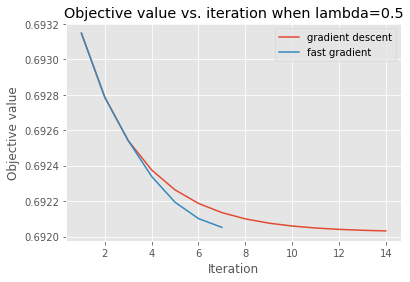

In [93]:
def objective_plot(betas_gd, betas_fg, lambduh, x=X_train, y=y_train):
    num_points_gd = np.size(betas_gd, 0)
    objs_gd = np.zeros(num_points_gd)
    num_points_fg = np.size(betas_fg, 0)
    objs_fg = np.zeros(num_points_fg)
    obj_fx(betas_fg[0, :], lambduh, X=x, y=y)
    for i in range(num_points_gd):
        objs_gd[i] = obj_fx(betas_gd[i, :], lambduh, X=x, y=y)
    for i in range(num_points_fg):
        objs_fg[i] = obj_fx(betas_fg[i, :], lambduh, X=x, y=y)
    fig, ax = plt.subplots()
    ax.plot(range(1, num_points_gd + 1), objs_gd,label='gradient descent')
    ax.plot(range(1, num_points_fg + 1), objs_fg,label='fast gradient')
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    plt.title('Objective value vs. iteration when lambda='+str(lambduh))
    ax.legend(loc='upper right')
    plt.show()
    
    
objective_plot(graddesc, fastAlgo, lamda)
